# Response time minimization problem for Oslo

- Goal: Minimize the response time of police vehicles in the city of Oslo, Norway.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.
- PuLP's standard CBC solver is used to solve the problem.

Pipeline was previously developed for a smaller area in Grünerløkka, Oslo. This notebook test pipeline for a larger network over the whole Oslo area.

Area: Oslo municipality, minus Nordmarka (medium network)  
Obj. func: Minimize total response time  
Event points: Sample from original network nodes
Event weight: None  
Possible car locations: Sampled from original network nodes and filtered by centrality and proximity
Car service distance: 800m  
Car max capacity: 300 events  
Implementation: OSMnx, NetworkX, Pandana, PuLP, Descartes  
Computation time: Node centrality (4min 6sec), PuLP add constraints (6min 18sec) + solve (4min 38sec)

In [74]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-03-12T19:19:11.464857+01:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import nearest_points, unary_union
from descartes import PolygonPatch
from pyproj import Transformer
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import pulp

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

numpy     : 1.26.4
shapely   : 2.0.3
pandana   : 0.7
osmnx     : 1.9.1
matplotlib: 3.8.3
networkx  : 3.2.1
geopandas : 0.14.3
pulp      : 2.8.0
pandas    : 2.2.1



## 1. Load the data
### 1.1 Load road network of Oslo

We load a road network of Oslo that has been slightly preprocessed.
- Network type: drive
- Oslo area minus Nordmarka
- CRS: UTM33N
- Includes edge weights (travel time in seconds)

First the administrative boundary of Oslo was found by `ox.geocode_to_gdf("Oslo, Norway")`. The Nordmarka area (the northern forest area; `ox.geocode_to_gdf("Nordmarka, Norway", which_result=1)`) was subtracted from the large Oslo area. Finally, the road network was queried from the polygon with `ox.graph_from_polygon(oslo_boundary.geometry[0], network_type='drive')`. The road network was then saved to graphml format.

For all input data we change the CRS from WGS84 to UTM33N. This is done to make the distance calculations easier.

In [76]:
### Road network file of Oslo, Norway

# 1) Read from local path
# oslo_filepath = "../data/grünerlokka_road_network.gpkg"    # GeoPackage format
oslo_filepath = "../data/OsloDriveImputed.graphml" # with travel time attribute
oslo_graph = ox.load_graphml(oslo_filepath) # originally in WGS84 (EPSG:4326)


# 2) Fetch from OSM - using OSMnx 
# oslo_graph = ox.graph_from_place('Oslo, Norway', network_type="drive") # originally in WGS84 (EPSG:4326)

Type of oslo_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of oslo_graph:  EPSG:32633


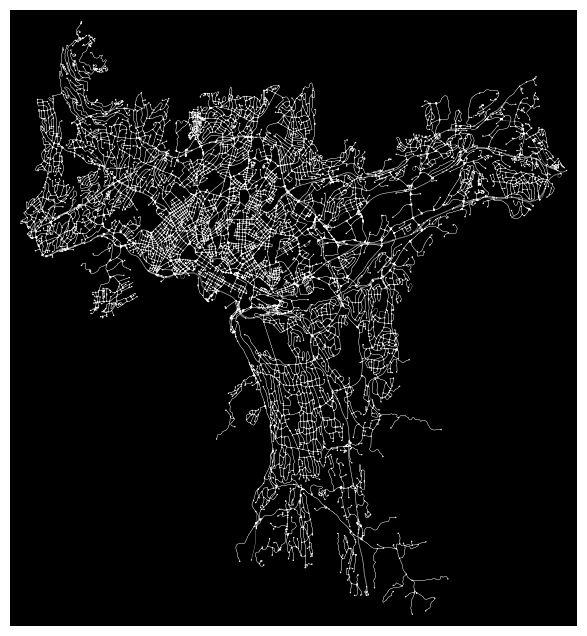

In [77]:
# oslo_graph = ox.projection.project_graph(oslo_graph, to_crs='EPSG:32633') # if need to project to UTM zone 33N
print(f"Type of oslo_graph: {type(oslo_graph)}")
print(f"CRS of oslo_graph:  {oslo_graph.graph['crs']}")

# plot graph
fig, ax = ox.plot_graph(oslo_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Convert graph to GeoDataFrame and plot it.   
`osmnx.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)` - Convert a MultiDiGraph to node and/or edge GeoDataFrames.

In [78]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(oslo_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
nodes.head()
# edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


,y,x,street_count,lon,lat,highway,ref,geometry
osmid,,,,,,,,
110,6653336.868,264559.267,4,10.783,59.950,NaN,NaN,POINT (264559.267 6653336.868)
115,6653477.248,264359.699,4,10.780,59.951,NaN,NaN,POINT (264359.699 6653477.248)
277510,6653217.017,264651.986,4,10.785,59.949,NaN,NaN,POINT (264651.986 6653217.017)
114,6653418.196,264616.856,3,10.784,59.951,NaN,NaN,POINT (264616.856 6653418.196)
113,6653212.483,264468.241,5,10.782,59.949,NaN,NaN,POINT (264468.241 6653212.483)


## 2. Add centrality measure as node attribute

Next we compute closeness centrality and add it as an attribute to the nodes GeoDataFrame.  

*Closeness centrality is a measure of how close a node is to all other nodes in the network. It is calculated as the reciprocal of the sum of the shortest path distances from the node to all other nodes in the graph.*

TODO: Find faster way to compute closeness centrality.

In [79]:
# %%time # TIME CONSUMING
# # compute node closeness centrality from scratch
# node_centrality = nx.closeness_centrality(oslo_graph, wf_improved=True, distance="travel_time")

In [80]:
# # add node closeness centrality to the nodes GeoDataFrame
# nodes['closeness_centrality'] = pd.Series(node_centrality)
# nodes.head(2)

In [81]:
# # Save node closeness centrality to file
# nodes_centrality_save = nodes[['closeness_centrality']]
# nodes_centrality_save.to_csv("C:/Users/torha/prog.div/PiT/LinearProgramming/data/OsloNodeCentrality.csv", index=True)

# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/OsloNodeCentrality.csv")
nodes = nodes.join(nodes_centrality_import.set_index('osmid'), on='osmid')
nodes.head(2)

,y,x,street_count,lon,lat,highway,ref,geometry,closeness_centrality
osmid,,,,,,,,,
110,6653336.868,264559.267,4,10.783,59.950,NaN,NaN,POINT (264559.267 6653336.868),0.002
115,6653477.248,264359.699,4,10.780,59.951,NaN,NaN,POINT (264359.699 6653477.248),0.002


Now, that the closeness centrality is added as an attribute to the ``nodes`` GeoDataFrame, we can use this to filter out better candidate locations for the police cars.

## 2. Sample event points

In [82]:
# random nodes from the graph
seed = 4
nr_of_car_nodes = 40
nodes_sample = nodes.sample(1010, random_state=seed) # sample X random source nodes
car_nodes = nodes_sample.iloc[:nr_of_car_nodes]   # first Y nodes are cars
event_nodes = nodes_sample.iloc[nr_of_car_nodes:] # rest of nodes are events
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}, nr of event nodes: {len(event_nodes)}")
nodes_sample.head(2)

Total nr of nodes: 8097, nr of police car nodes: 40, nr of event nodes: 970


,y,x,street_count,lon,lat,highway,ref,geometry,closeness_centrality
osmid,,,,,,,,,
3185943,6651981.230,260465.596,4,10.712,59.935,NaN,NaN,POINT (260465.596 6651981.230),0.002
1211014476,6650067.749,262823.289,2,10.756,59.920,NaN,NaN,POINT (262823.289 6650067.749),0.002


## 3. Filter/Selection of police car candidate points
We have sampled random points from the road network. Next we filter the candidate points on the following critera to discard the most unsuitable points. This will reduce computational time and make the LP problem more manageable.

- Discard nodes with lowest closeness centrality (i.e. nodes that are not well connected to the rest of the network)
- Discard nodes that are too close to each other


Input nr of car nodes: 40
Remaining nr of car nodes: 32, after discarding the 8 (20%) remote car nodes with lowest closeness centrality



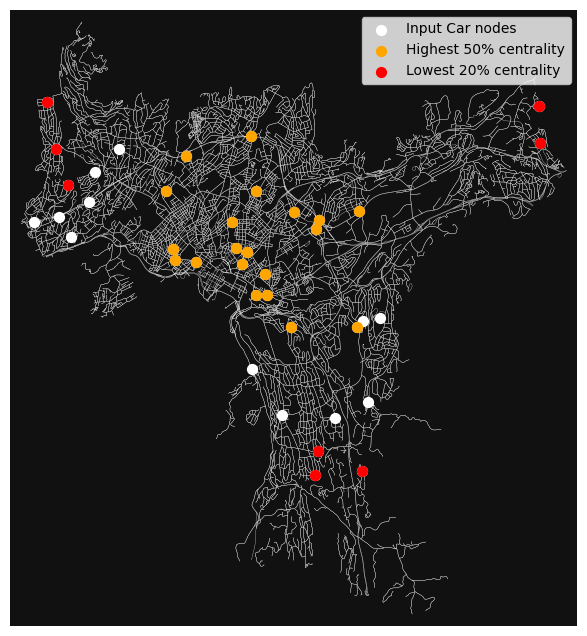

In [83]:
# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))

def filter_and_plot_nodes_by_centrality(geo_df, top_percent, bottom_percent, input_graph, plot=False):
    """
    Filters a GeoDataFrame to find the top X% and bottom Y% of nodes based on closeness_centrality,
    optionally plots these nodes, and returns a filtered GeoDataFrame excluding the bottom Y% nodes.
    
    :param geo_df: GeoDataFrame with a 'closeness_centrality' column and 'x', 'y' for plotting.
    :param top_percent: The top percentage of nodes to select based on closeness_centrality.
    :param bottom_percent: The bottom percentage of nodes to select based on closeness_centrality.
    :param plot: Whether to plot the nodes.
    :return: A filtered GeoDataFrame excluding the bottom Y% closeness_centrality nodes.
    """
    # Calculate the number of nodes for each selection
    num_top = int(len(geo_df) * top_percent)
    num_bottom = int(len(geo_df) * bottom_percent)
    
    # Sort the DataFrame by closeness_centrality
    sorted_geo_df = geo_df.sort_values(by='closeness_centrality', ascending=False)
    
    # Select the top X% and bottom Y%
    central_car_nodes = sorted_geo_df.head(num_top)
    remote_car_nodes = sorted_geo_df.tail(num_bottom)
    
    # print(f"Selection of {top_percent*100}% highest and {bottom_percent*100}% lowest closeness centrality car nodes\nTotal nr of nodes: {len(sorted_geo_df)}\nNr of remote car nodes: {len(remote_car_nodes)},\nNr of central car nodes: {len(central_car_nodes)}")
    

    print(f"Input nr of car nodes: {len(geo_df)}")
    print(f"Remaining nr of car nodes: {len(sorted_geo_df) - len(remote_car_nodes)}, after discarding the {len(remote_car_nodes)} ({bottom_percent*100:.0f}%) remote car nodes with lowest closeness centrality\n")
    if plot:
        # Plot all nodes
        fig, ax = ox.plot_graph(input_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False)
        ax.scatter(geo_df['x'], geo_df['y'], c='white', s=50, label="Input Car nodes")
        ax.scatter(central_car_nodes['x'], central_car_nodes['y'], c='orange', s=50, label=f"Highest {top_percent*100:.0f}% centrality")
        ax.scatter(remote_car_nodes['x'], remote_car_nodes['y'], c='red', s=50, label=f"Lowest {bottom_percent*100:.0f}% centrality")
        ax.legend()
        plt.show()
    
    # Remove the bottom Y% nodes from the original GeoDataFrame
    filtered_geo_df = sorted_geo_df.drop(remote_car_nodes.index)
    return filtered_geo_df

car_nodes_gdf_central = filter_and_plot_nodes_by_centrality(geo_df=car_nodes_gdf, top_percent=0.5, bottom_percent=0.20, input_graph=oslo_graph, plot=True)

Input nr of car nodes: 32
Remaining nr of car nodes: 16, after removing the 16 nodes that are within 1300 m of each other



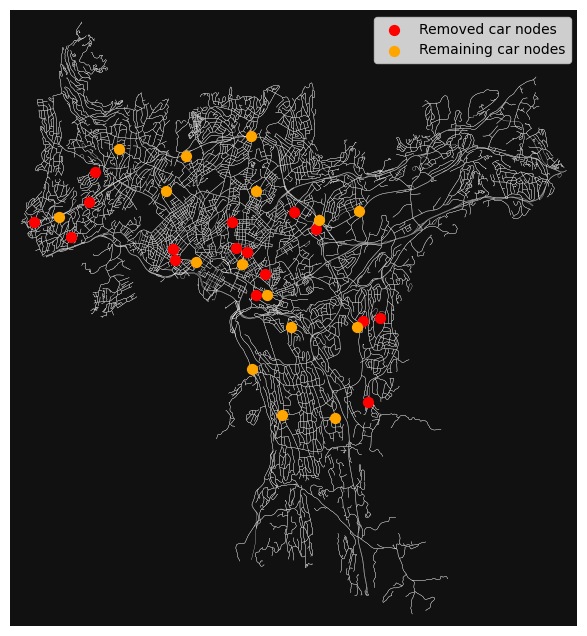

In [84]:
def filter_nodes_by_proximity(geo_df, min_distance, input_graph, criterion_col=None, prefer='higher', plot=False):
    """
    Removes nodes from a GeoDataFrame that are within a specified minimum distance of each other.
    
    :param geo_df: GeoDataFrame with a 'geometry' column.
    :param min_distance: Minimum distance in the GeoDataFrame's coordinate reference system units.
    :param input_graph: The graph from which the nodes were extracted, used for plotting.
    :param criterion_col: Column name to use as a criterion for removing nodes. Optional.
    :param prefer: Determines which node to keep based on the criterion_col ('higher' or 'lower').
    :param plot: Whether to plot the nodes.
    :return: A filtered GeoDataFrame excluding nodes within the minimum distance of each other.
    """
    sindex = geo_df.sindex # Create a spatial index for the GeoDataFrame
    to_remove = [] # List to keep track of indices to remove
    
    # Iterate over the GeoDataFrame
    for index, row in geo_df.iterrows():
        # Create a buffer around the geometry and find potential matches using the spatial index
        buffer = row.geometry.buffer(min_distance)
        possible_matches_index = list(sindex.intersection(buffer.bounds))
        possible_matches = geo_df.iloc[possible_matches_index]
        
        # Actual neighbors are those within the specified distance, excluding the row itself
        actual_neighbors = possible_matches[possible_matches.distance(row.geometry) < min_distance]
        actual_neighbors = actual_neighbors.drop(index, errors='ignore')
        
        for neighbor_index, neighbor in actual_neighbors.iterrows():
            if criterion_col:
                # Decide which node to remove based on the criterion
                if (prefer == 'higher' and neighbor[criterion_col] > row[criterion_col]) or \
                   (prefer == 'lower' and neighbor[criterion_col] < row[criterion_col]):
                    to_remove.append(index)
                    break  # Current node will be removed, no need to check other neighbors
                else:
                    to_remove.append(neighbor_index)
            else:
                # If no criterion is given, default to removing the neighbor
                to_remove.append(neighbor_index)
    
    # Remove duplicates and drop the nodes
    to_remove = list(set(to_remove))
    filtered_geo_df = geo_df.drop(index=to_remove)
    
    # Reset index to clean up the DataFrame
    filtered_geo_df.reset_index(drop=True, inplace=True)

    print(f"Input nr of car nodes: {len(geo_df)}")
    print(f"Remaining nr of car nodes: {len(geo_df) - len(to_remove)}, after removing the {len(to_remove)} nodes that are within {min_distance} m of each other\n")

    if plot:
        # Plot all nodes
        fig, ax = ox.plot_graph(input_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False)
        ax.scatter(geo_df.loc[to_remove, 'x'], geo_df.loc[to_remove, 'y'], c='red', s=50, label="Removed car nodes")
        ax.scatter(filtered_geo_df['x'], filtered_geo_df['y'], c='orange', s=50, label=f"Remaining car nodes")
        ax.legend(); plt.show()
    return filtered_geo_df

car_nodes_gdf_filtered = filter_nodes_by_proximity(geo_df=car_nodes_gdf_central, min_distance=1300, input_graph=oslo_graph, criterion_col='closeness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

Now we use the GeoDataFrames from `osmnx` to create a `pandana` network.

Pandana networks is defined like this:   
`pandana.network.Network(node_x, node_y, edge_from, edge_to, edge_weights, twoway=True)`  

 **edge_weights**: DataFrame, all numerics   
- Specifies one or more impedances on the network which define the distances between nodes.  
- Multiple impedances can be used to capture travel times at different times of day, for instance.

We will use both ``length`` and ``travel_time`` as edge weights. However, we must specify which one to use when querying the network (cannot calculate with both at the same time).

In [85]:
# reset index so our origins and destinations are not in index
edges = edges.reset_index()

# create network with pandana
oslo_pandana_network = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of oslo_pandana_network: {type(oslo_pandana_network)}")
print(f"Network nodes:")
oslo_pandana_network.nodes_df.head(3)

type of oslo_pandana_network: <class 'pandana.network.Network'>
Network nodes:


,x,y
osmid,,
110,264559.267,6653336.868
115,264359.699,6653477.248
277510,264651.986,6653217.017


In [86]:
print(f"Network edges: ")
oslo_pandana_network.edges_df.head(3)

Network edges: 


,from,to,length,travel_time
0,110,115,243.278,28.500
1,110,277510,151.771,17.800
2,110,114,99.389,11.700


Next, it’s probably a good idea (though not strictly required) to precompute a given horizon distance so that aggregations don’t perform the network queries unnecessarily.   
This is done by calling the following code, where 3000 meters is used as the horizon distance:

In [87]:
oslo_pandana_network.precompute(3000)

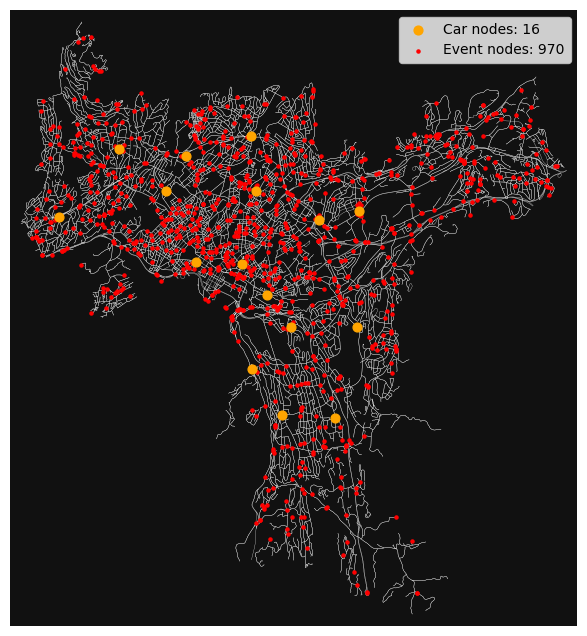

In [88]:
# Plot nodes for overview using ox.plot
fig, ax = ox.plot_graph(oslo_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False)
# add number of events and car nodes to the legend
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='orange', s=40, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_nodes['x'], event_nodes['y'], c='red', s=5, label=f"Event nodes: {len(event_nodes)}", zorder=2)
ax.legend(); plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

First, identify the nearest node to each Police car and Event.
- [network.get_node_ids()](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids)

In [89]:
# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = oslo_pandana_network.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
event_nodes_pdna = oslo_pandana_network.get_node_ids(x_col=event_nodes.x, y_col=event_nodes.y).values
# car_nodes_pdna

In [90]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

# for o, d in zip(origins, destinations):
#     print(f"{o}, {d}")

In [91]:
%%time
# distance between each possible pair of facilities-clients combination
distances = oslo_pandana_network.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = oslo_pandana_network.shortest_path_lengths(origins, destinations, imp_name='travel_time')

print(type(distances))
print("Number of distances calculated: ", len(distances), "\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5], "\n")

<class 'list'>
Number of distances calculated:  15520 

5 first origin-destination distances [m]     : [4784.772, 5772.682, 3662.308, 3670.76, 7081.1]
5 first origin-destination travel times [sec]: [252.1, 404.1, 229.6, 259.9, 437.9] 

CPU times: total: 828 ms
Wall time: 96.9 ms


In [92]:
# print the statistics for distances and travel times
print("Distances statistics:")
print(pd.Series(distances).describe())
print("\nTravel times statistics:")
print(pd.Series(travel_times).describe())

Distances statistics:
count   15520.000
mean     7322.140
std      3745.761
min        37.862
25%      4445.823
50%      6830.395
75%      9891.398
max     20876.155
dtype: float64

Travel times statistics:
count   15520.000
mean      511.939
std       234.706
min         2.800
25%       337.900
50%       489.300
75%       667.700
max      1545.300
dtype: float64


In [93]:
# Restructure the distances and travel times arrays into a DataFrame (Cost Matrix) and add the car and event node ids as columns

# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['policeCarNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
# CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(car_nodes_gdf_filtered, left_on='policeCarNodeID', right_index=True)
CostMatrix_extended = CostMatrix.merge(event_nodes, left_on='eventNodeID', right_index=True, suffixes=('_car', '_event'))
# CostMatrix_extended.keys()
CostMatrix_extended.head(3)

,distance,travel_time,policeCarNodeID,eventNodeID,y,x,street_count,lon,lat,highway,ref,geometry,closeness_centrality
0,4784.772,252.100,1762320662,820424111,6647134.367,265360.656,3,10.805,59.895,NaN,NaN,POINT (265360.656 6647134.367),0.002
1,5772.682,404.100,1762320662,270301113,6648317.075,261862.994,4,10.741,59.903,NaN,NaN,POINT (261862.994 6648317.075),0.002
2,3662.308,229.600,1762320662,25328783,6648570.941,265295.104,3,10.802,59.908,NaN,NaN,POINT (265295.104 6648570.941),0.002


In [94]:
# # Save cost matrix to CSV
# CostMatrix.to_csv("../data/OsloCostMatrix.csv", index=False)

# # import cost matrix from CSV
# CostMatrix_imported = pd.read_csv("../data/OsloCostMatrix.csv")
# CostMatrix_imported.head()

Now, we have made Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Model the problem
We will use the Python library PuLP to model and solve the optimization problem.

The objective is to minimize the average response time to events, by optimally positioning a fixed number of police cars.

### Notation

Let's define the notation that will be used to formulate the problem:
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events, each associated with a node in $N$ and a severity score.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.

### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M_i \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$

This mathematical formulation provides a clear LP framework for optimizing the placement of police cars to minimize response times, ensuring each event is adequately covered. The next step, translating this formulation into Python code, involves using an LP solver like PulP to define and solve this optimization problem.


#### Setup LP problem

In [119]:
# Constants
K = 4  # Number of police car locations in final solution
M = 250   # Maximum number of events a single police car can respond to

# Sets
P = CostMatrix['policeCarNodeID'].unique()  # Potential police car locations
E = CostMatrix['eventNodeID'].unique()  # Events

# Preprocessing options for performance (becomes more relevant when scaling up to larger area)
# Pre-compute mappings or aggregations that can reduce the complexity or number of iterations required during constraint setup.
# E.g. only check events within a certain distance of each police car location.

# Create the LP object
# Minimization problem since we want to minimize the total travel time
problem = pulp.LpProblem("PoliceCarLocationOptimization", pulp.LpMinimize) # Minimization problem
problem

PoliceCarLocationOptimization:
MINIMIZE
None
VARIABLES

#### Add decision variables and objective function

In [120]:
%%time
# Decision Variables
# x[i] = 1 if a police car is placed at location i, 0 otherwise
x = pulp.LpVariable.dicts("x", P, cat='Binary')  # Police car placement
# y[i, j] = 1 if event j is assigned to police car i, 0 otherwise
y = pulp.LpVariable.dicts("y", [(i, j) for i in P for j in E], cat='Binary')  # Event assignment

# Objective Function
# Minimize the total response time
problem += pulp.lpSum([CostMatrix.set_index(['policeCarNodeID', 'eventNodeID']).loc[(i, j), 'travel_time'] * y[(i, j)] for i in P for j in E]), "TotalResponseTime"
# This is the same as:
# for i in P:
#     for j in E:
#         problem += CostMatrix.loc[(i, j), 'travel_time'] * y[(i, j)]

CPU times: total: 23.6 s
Wall time: 26.8 s


#### Add problem constraints

In [121]:
%%time
# Police Car Placement Constraint
problem += pulp.lpSum([x[i] for i in P]) == K, "NumberOfPoliceCars"
# This is the same as:
# for i in P:
#     problem += x[i] <= 1
# And means that we can only place a police car at one location

# Event Assignment Constraint
for j in E:
    problem += pulp.lpSum([y[(i, j)] for i in P]) == 1, f"EventAssignment_{j}"
# This is the same as:
# for j in E:
#     for i in P:
#         problem += y[(i, j)] <= 1
# And means that each event must be assigned to exactly one police car

# Validity Constraint
for i in P:
    for j in E:
        problem += y[(i, j)] <= x[i], f"Validity_{i}_{j}"
# This is the same as:
# for i in P:
#     for j in E:
#         problem += y[(i, j)] <= x[i]
# And means that we can only assign an event to a police car if it is placed at that location

# Capacity Constraint
for i in P:
    problem += pulp.lpSum([y[(i, j)] for j in E]) <= M * x[i], f"Capacity_{i}"
# This is the same as:
# for i in P:
#     problem += pulp.lpSum([y[(i, j)] for j in E]) <= M * x[i]
# And means that each police car can only respond to a maximum of M events

CPU times: total: 203 ms
Wall time: 290 ms


#### Run the solver - using the default solver (CBC)

In [122]:
%%time
# TODO: check out setting optimality gap (fracGap=0.1) for faster approximate solutions 

# Solve the problem - using the default solver (CBC)
status = problem.solve(pulp.PULP_CBC_CMD()) # CBC is the default solver

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Goal: minimize the objective function (total response time)")
print(f"Objective function value: {pulp.value(problem.objective):.2f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")

status: 1, Optimal
Goal: minimize the objective function (total response time)
Objective function value: 253050.89 seconds, or 4217.51 minutes, or 70.29 hours
CPU times: total: 281 ms
Wall time: 19.6 s


.solve() calls the underlying solver, modifies the model object, and returns the integer status of the solution, which will be 1 if the optimum is found.   
 For the rest of the status codes, see [LpStatus](https://www.coin-or.org/PuLP/constants.html#pulp.constants.LpStatus).

 
| LpStatus key         | string value  | numerical value |
|----------------------|---------------|-----------------|
| LpStatusOptimal      | "Optimal"     | 1               |
| LpStatusNotSolved    | "Not Solved"  | 0               |
| LpStatusInfeasible   | "Infeasible"  | -1              |
| LpStatusUnbounded    | "Unbounded"   | -2              |
| LpStatusUndefined    | "Undefined"   | -3              |

You can get the optimization results as the attributes of model. The function value() and the corresponding method .value() return the actual values of the attributes

### 5.2 Inspect the results

In [123]:
# Results Processing

# convert to array
optimal_police_locations = [i for i in P if x[i].varValue == 1]
assigned_events = {j: i for i in P for j in E if y[(i, j)].varValue == 1}

print(f"Optimal police car locations: {optimal_police_locations}, type: {type(optimal_police_locations)}")
# print(f"Assigned events: {assigned_events}, type: {type(assigned_events)}")

# group the events by police car
events_by_police_car = {} # structured as {police_car: [event1, event2, ...]}
for event, police_car in assigned_events.items():
    if police_car in events_by_police_car:
        events_by_police_car[police_car].append(event)
    else:
        events_by_police_car[police_car] = [event]

# print(f"Events by police car: {events_by_police_car}, type: {type(events_by_police_car)}")

Optimal police car locations: [25665506, 791444951, 1949506801, 6952663466], type: <class 'list'>


In [124]:
# Next is creating GeoDataFrames for the police car locations and the assigned events with coordinates

# Get the coordinates of the optimal police car locations
optimal_police_car_locations_gdf = nodes[nodes.index.isin(optimal_police_locations)]
# optimal_police_car_locations_gdf.head(2)

# export optimal_police_car_locations_gdf to CSV
optimal_police_car_locations_gdf.to_csv('../data/OsloOptimalLocations.csv', index=False)

# Get the coordinates of the assigned events
assigned_events_gdf = nodes[nodes.index.isin(list(assigned_events.keys()))]
# print(type(assigned_events_gdf))
# assigned_events_gdf.head(2)

## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 253051 sec | 4217.5 min | 70.29 hours

Police car id:25665506 handles 250 events | Capacity 100 % | Total response time: 28105 min | Avg response time: 7.0 min
Police car id:791444951 handles 250 events | Capacity 100 % | Total response time: 36118 min | Avg response time: 9.0 min
Police car id:1949506801 handles 250 events | Capacity 100 % | Total response time: 36311 min | Avg response time: 9.1 min
Police car id:6952663466 handles 220 events | Capacity 88 % | Total response time: 31888 min | Avg response time: 9.1 min


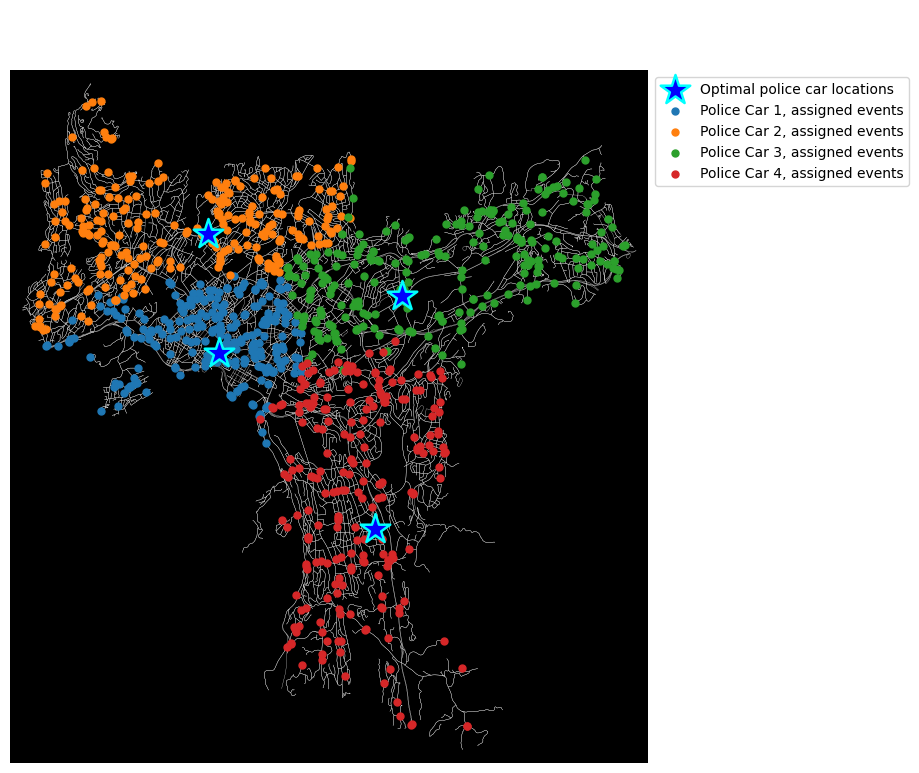

In [125]:
# Do the same plot, but using ox.plot
fig, ax = ox.plot_graph(oslo_graph, node_color="white", node_size=0, bgcolor='k', edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,9))
# ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='blue', edgecolor='cyan', linewidth=1.3, marker='d', s=80, label="Possible police car locations", zorder=3, alpha=0.7)
ax.scatter(optimal_police_car_locations_gdf['x'], optimal_police_car_locations_gdf['y'], color='blue', marker='*', edgecolor='cyan', linewidth=1.8, s=500, label="Optimal police car locations", zorder=3)
for i, police_car in enumerate(optimal_police_car_locations_gdf.index):
    assigned_events_gdf[assigned_events_gdf.index.isin(events_by_police_car[police_car])].plot(ax=ax, color=f'C{i}', markersize=25, label=f'Police Car {i+1}, assigned events') # Events from police car i
ax.set_title("Optimal locations using 4 police cars, with their assigned events\n Objective: minimize total response time", fontsize=14, color='white')
legend = ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1))

print("Solution from Linear Programming (LP) model:")
print(f"Goal: minimize objective function (total response time)")
print(f"Objective function value: {pulp.value(problem.objective):.0f} sec | {pulp.value(problem.objective)/60:.1f} min | {pulp.value(problem.objective)/3600:.2f} hours\n")
for police_car, events in events_by_police_car.items():
    # print(f"Police car id:{police_car} handles {len(events)} events, using {len(events)/M*100:.0f}% of its capacity. Total response time of {sum(CostMatrix_extended.loc[CostMatrix_extended['eventNodeID'].isin(events), 'travel_time'])/60:.0f} minutes. Average response time of {np.mean(CostMatrix_extended.loc[CostMatrix_extended['eventNodeID'].isin(events), 'travel_time'])/60:.1f} minutes")
    print(f"Police car id:{police_car} handles {len(events)} events | Capacity {len(events)/M*100:.0f} % | Total response time: {sum(CostMatrix_extended.loc[CostMatrix_extended['eventNodeID'].isin(events), 'travel_time'])/60:.0f} min | Avg response time: {np.mean(CostMatrix_extended.loc[CostMatrix_extended['eventNodeID'].isin(events), 'travel_time'])/60:.1f} min")
plt.show()

All event weights are equal in this example.

## 6.2 Visualize Isochrones - How far can you drive in different time intervals?
How far can you drive in 1.5, 4 and 8 minutes from the origin nodes? We'll use NetworkX to induce a subgraph of gruner_graph within each distance, based on travel time.  
We also, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [126]:
# Define how many trip times to visualize
TRIP_TIMES = [2, 4, 8]  # in minutes
ISO_COLORS = ['blue', 'magenta', 'yellow']  # Long, Middle, Short ranges

In [127]:
# Create isochrone polygons
def make_iso_polys(G, center_nodes, edge_buff=30, node_buff=0, infill=True):
    """
    Generate isochrone polygons for given center nodes in a graph.
    """
    all_isochrone_polys = []
    for center_node in center_nodes:
        isochrone_polys = []
        for trip_time in sorted(TRIP_TIMES, reverse=True):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time*60, distance='travel_time')
            if subgraph.number_of_nodes() == 0 or subgraph.number_of_edges() == 0:
                # Skip if subgraph is empty
                continue
            
            # Mapping node IDs to Points
            node_id_to_point = {node: Point(data['x'], data['y']) for node, data in subgraph.nodes(data=True)}
            
            edge_lines = []
            for n_from, n_to in subgraph.edges():
                f_point = node_id_to_point[n_from]
                t_point = node_id_to_point[n_to]
                edge_lines.append(LineString([f_point, t_point]))

            # Buffer nodes and edges, then combine
            n = gpd.GeoSeries([node_id_to_point[node] for node in subgraph.nodes()]).buffer(node_buff)
            e = gpd.GeoSeries(edge_lines).buffer(edge_buff)
            all_gs = list(n) + list(e)
            new_iso = gpd.GeoSeries(all_gs).unary_union
            
            # Handling infill
            if infill and isinstance(new_iso, Polygon):
                new_iso = Polygon(new_iso.exterior)
                
            isochrone_polys.append(new_iso)
        all_isochrone_polys.append(isochrone_polys)
    return all_isochrone_polys

In [128]:
# Merge isochrones to prevent overlap
def merge_isochrones(G, isochrone_polys):
    """
    Merge isochrones to prevent overlap.
    """
    # Initialize containers for merged isochrones by range
    merged_short = []; merged_middle = []; merged_long = []

    # Populate the lists with polygons to merge
    for location_polygons in isochrone_polys:
        if len(location_polygons) >= 1:
            merged_short.append(location_polygons[0])  # Assuming first is short-range
        if len(location_polygons) >= 2:
            merged_middle.append(location_polygons[1])  # Assuming second is middle-range
        if len(location_polygons) == 3:
            merged_long.append(location_polygons[2])  # Assuming third is long-range

    # Perform the merging
    merged_short_union = unary_union(merged_short)
    merged_middle_union = unary_union(merged_middle)
    merged_long_union = unary_union(merged_long)
    return merged_short_union, merged_middle_union, merged_long_union

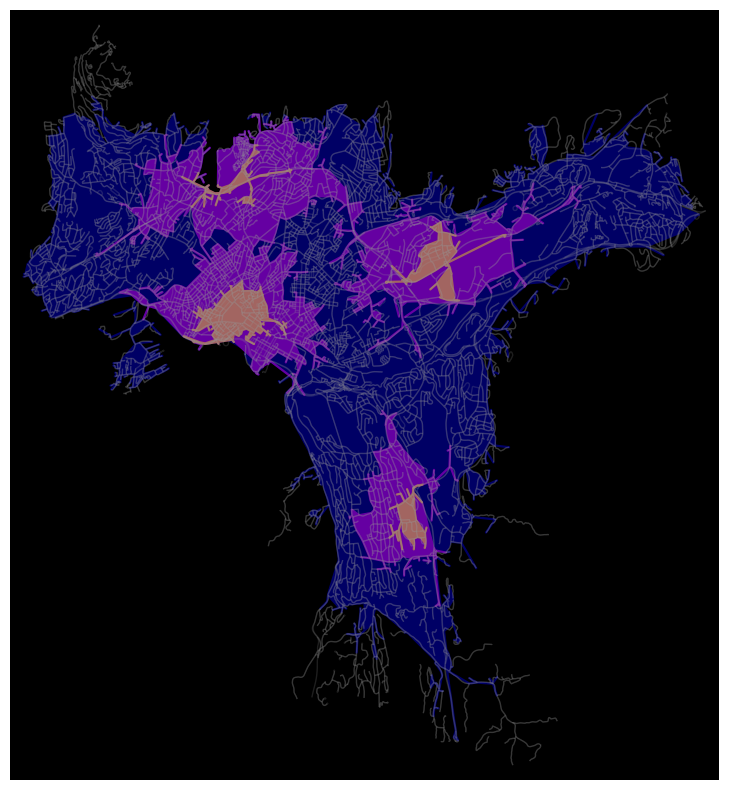

CPU times: total: 17.6 s
Wall time: 20.3 s


In [129]:
%%time
# Generate isochrone polygons
isochrone_polys = make_iso_polys(oslo_graph, optimal_police_locations)

# Merge isochrones
merged_isochrones = merge_isochrones(oslo_graph, isochrone_polys)

# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(oslo_graph, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0, bgcolor='k', figsize=(12, 10))

# Plotting merged isochrones with colors
# iso_colors = ['blue', 'magenta', 'yellow']  # Long, Middle, Short ranges
for merged_poly, color in zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS):
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=0.4, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=0.4, zorder=-1)
        ax.add_patch(patch)
plt.show()

### 6.3 Plot isochrones on interactive leaflet map

In [130]:
# reverse order of trip_times
TRIP_TIMES.sort(reverse=True)

# Prepare data for GeoDataFrame
data = {
    'trip_time': TRIP_TIMES,
    'geometry': [
        merged_isochrones[0],
        merged_isochrones[1],
        merged_isochrones[2]
    ]
}
# Convert dictionary to GeoDataFrame
crs_proj = ox.graph_to_gdfs(oslo_graph, nodes=False).crs  # Adjusted to explicitly state nodes=False
isochrones_gdf = gpd.GeoDataFrame(data, crs=crs_proj)

# Visualize the merged isochrones on a Leaflet map
leaflet_map = isochrones_gdf.explore(
    column='trip_time',  # trip_time column to differentiate the isochrones
    cmap='RdPu',  # color map
    tiles='OpenStreetMap',  # 'OpenStreetMap' for light tiles, 'CartoDB dark_matter' for dark tiles
    style_kwds={'fillOpacity': 0.5, 'lineOpacity': 0.7},  # Adjust opacities as needed
    legend=True  # Legend to differentiate ranges
)
leaflet_map